In [1]:
from typing import List

import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(keep_attrs=True,
               display_expand_data=False)

import plotly.express as px
import plotly.io as pio
# pio.renderers.default='png'

import yfinance as yf


In [2]:
def xr_pct_change(da: xr.DataArray, dim: str, periods: int = 1) -> xr.DataArray:
    """
    Calculate the percent change between values of an xarray DataArray along a specified dimension,
    similar to the pandas pct_change function.

    Parameters
    ----------
    da : xr.DataArray
        The input xarray DataArray.
    dim : str
        The dimension along which to calculate the percent change.
    periods : int, optional
        The number of periods to shift for calculating percent change, by default 1.

    Returns
    -------
    xr.DataArray
        DataArray of the same shape with percent changes computed along the specified dimension.

    Examples
    --------
    >>> da = xr.DataArray([1, 2, 4, 8], dims='time')
    >>> xr_pct_change(da, dim='time')
    <xarray.DataArray (time: 4)>
    array([nan, 1. , 1. , 1. ])
    Dimensions without coordinates: time

    Notes
    -----
    - Generated by ChatGPT (v2.0) on 2024-10-22.
    - Prompt: "Please write a pct_change function for an xarray DataArray in the style of pandas pct_change function.
      Please be careful to note that the diff function in xarray uses the numpy convention, not the pandas convention."
    """
    shifted = da.shift({dim: periods})
    pct_change = (da - shifted) / shifted
    pct_change = pct_change.where(~np.isinf(pct_change))  # Handle division by zero cases
    return pct_change

In [3]:
def get_yf_data(asset_list: List[str]) -> xr.DataArray:
    return (yf.download(asset_list)
            .rename_axis(index='date', columns=['OHLCV', 'asset'])
            .rename(columns={'Adj Close': 'cret', 
                             'Close': 'level'},
                    index={'Ticker': 'asset'})
            .rename(columns=lambda col: col.lower(), level='OHLCV')
            .stack('asset', future_stack=True)
            .to_xarray()
            )

In [4]:
factor_master = pd.read_excel('monitor.xlsx', sheet_name='read', index_col='factor_name')
asset_list = factor_master.query('active == 1')['etf'].to_list()

In [5]:
def get_volatility_set(ret, halflifes):
    return xr.concat([ds.ret.rolling_exp({'date': h}, window_type='halflife').std() 
                       for h in halflifes],
                       dim=pd.Index(halflifes, name='vol_type'))

In [6]:
def get_ewm_corr(ret, halflife):
    return (ret.to_pandas()
            .ewm(halflife=halflife)
            .corr()
            .rename_axis(columns=lambda name: f"{name}_1")
            .stack()
            # .rename_axis(['date', 'ticker', 'ticker_1'])
            .rename('corr')
            .to_xarray())

def get_correlation_set(ret, halflifes):
    return xr.concat([get_ewm_corr(ret, h) for h in halflifes],
                     dim=pd.Index(halflifes, name='corr_type'))

In [7]:
ds = get_yf_data(asset_list)
ds['ret'] = ds.cret.pipe(xr_pct_change, 'date')


[*********************100%%**********************]  6 of 6 completed


In [8]:
halflifes = [21, 63, 126, 252, 512]

ds['vol'] = get_volatility_set(ds.ret, halflifes)
ds['corr'] = get_correlation_set(ds.ret, halflifes)
ds

<xarray.Dataset> Size: 16MB
Dimensions:    (date: 7991, asset: 6, vol_type: 5, asset_1: 6, corr_type: 5)
Coordinates:
  * date       (date) datetime64[ns] 64kB 1993-01-29 1993-02-01 ... 2024-10-23
  * asset      (asset) object 48B 'FEZ' 'HYG' 'IWM' 'LQD' 'QQQ' 'SPY'
  * vol_type   (vol_type) int64 40B 21 63 126 252 512
  * asset_1    (asset_1) object 48B 'FEZ' 'HYG' 'IWM' 'LQD' 'QQQ' 'SPY'
  * corr_type  (corr_type) int64 40B 21 63 126 252 512
Data variables:
    cret       (date, asset) float64 384kB nan nan nan nan ... 109.2 488.4 578.0
    level      (date, asset) float64 384kB nan nan nan nan ... 109.2 488.4 578.0
    high       (date, asset) float64 384kB nan nan nan nan ... 109.5 494.2 581.7
    low        (date, asset) float64 384kB nan nan nan nan ... 109.1 485.0 574.4
    open       (date, asset) float64 384kB nan nan nan nan ... 109.2 493.6 581.3
    volume     (date, asset) float64 384kB nan nan nan ... 3.92e+07 4.923e+07
    ret        (date, asset) float64 384kB nan nan nan ... -0.01532 -0.009137
    vol        (vol_type, date, asset) float64 2MB nan nan nan ... 0.01408 0.011
    corr       (corr_type, date, asset, asset_1) float64 12MB nan nan ... 1.0

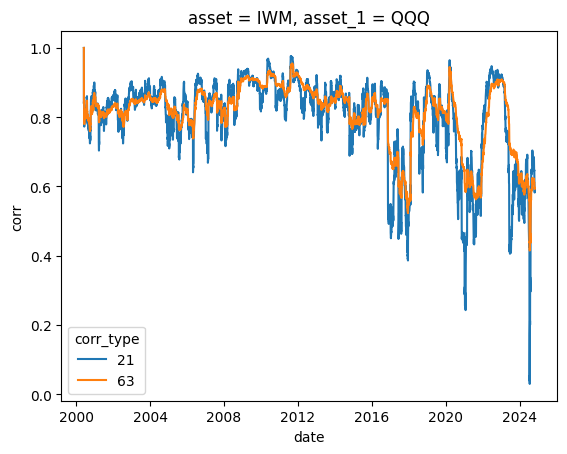

In [16]:
ds.corr.sel(corr_type=[21, 63], asset='IWM', asset_1='QQQ').plot(hue='corr_type')